# Plotting sea ice in the Southern Ocean
This script produces plots of sea ice area around the Southern Ocean using outputs from ACCESS-OM2-01.  
**Requirements:** It is suggested you use the `conda/analysis3-20.01` (or later) kernel. This can be defined using the drop down list on the left hand corner, or type `!module load conda/analysis3` in a Python cell.

## Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [1]:
#This first line will show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import os
import calendar
from dask.distributed import Client
#Activate if needed
# import copy

The following modules are used in map creation.

In [2]:
import cmocean as cm                              # Nice colormaps
from collections import OrderedDict               # We often use this to organise our experiments
import cftime                                     # In case you need to work with time axes
import glob                                       # If you need to search file systems
import cartopy.crs as ccrs                        # For making maps with different projections
import cartopy.feature as cft                     # For adding features to maps

## Accessing model outputs
Start a cluster that has multiple cores to work with. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [3]:
client = Client(n_workers = 4)

Access the default database of experiments from where data will be loaded.

In [4]:
session = cc.database.create_session()

This notebook uses the outputs for the v140 run of ACCESS-OM2-01 which includes wind forcing. Includes experiments `01deg_jra55v140_iaf` and `01deg_jra55v140_iaf`. A list of experiments can be accessed using `cc.querying.get_experiments(session)`, you can get a detailed list of experiments by adding `all = True` argument.

In [5]:
#Saving name of experiments of interest in variables that can be easily referred to
#expv140 = "01deg_jra55v140_iaf"
expv140_c2 = "01deg_jra55v140_iaf_cycle2"

### Experiment variables
You can query the temporal frequency of all variables available in the experiment using `cc.querying.get_frequencies(session, experiment)`. A list of experiment variables can be obtained using `cc.querying.get_variables(session, experiment, frequency)`.

In [ ]:
#Activate the lines below to query temporal frequency
#cc.querying.get_frequencies(session, expv140)

Asking for user input to query experiment variable list

In [7]:
#Querying experiment variables
expvar = cc.querying.get_variables(session, expv140, frequency = "1 monthly")

#Extract variables with keywords included in its long_name column
expvar[expvar["long_name"].str.lower().str.match(".*ice.*")] #force all letters to be lowercase to get matches

In [ ]:
#Deleting variables no longer in use
del expvar

## Accessing outputs
Once the correct experiment variables have been identified, data can be loaded into the notebook for further processing. All variables needed to do this are included below.

In [8]:
#Name of experiment(s)
#expv140
expv140_c2
#Name (short name) of variable of interest as identified in previous step
varInt = "aice_m" #monthly ice concentration

Optional variables, activate if needed. Note that because times need correction, **the start time is actually one month after the month we are interested in**. See below for explanation.

In [9]:
#The below variables are optional, activate as needed
#Date from when data should be extracted - Can be given as full date (e.g., 2010-01-01), just year and month, or just year
stime = '2010-02'
#End date from data extraction
etime = '2015-01'

Loading data using `cc.querying.getvar()`. Initially inspecting monthly variables as it is not possible to load more than 5 years of daily data. Daily data will be extracted for period of times when large changes in the variable being inspected are identified.

In [10]:
vararray = cc.querying.getvar(expv140_c2, varInt, session, frequency = '1 monthly', start_time = stime, end_time = etime)
vararray

<xarray.DataArray 'aice_m' (time: 60, nj: 2700, ni: 3600)>
dask.array<concatenate, shape=(60, 2700, 3600), dtype=float32, chunksize=(1, 675, 900), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2010-02-01 00:00:00 ... 2015-01-01 00:00:00
    TLON     (nj, ni) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(675, 900), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

## Data manipulation

**Times need to be corrected** because the time 00:00:00 is interpreted differently by the CICE model. For example, CICE links *2010-01-01 00:00:00* to the start of 2010-01-01, while xarray interprets it as the start of the day after. To fix this problem, 12 hours are subtracted from the time dimension (also known as *time coordinate*).

In [11]:
vararray['time'] = vararray.time - dt.timedelta(hours = 12)

The `aice_m` variable gives the mean monthly concentration of ice in a cell. In other words, this represents the monthly mean proportion of ice found in a given grid cell. To calculate the area covered by ice, the area of each cell is needed.  
The area is saved as `area_t` and it is given by the ocean model, below we will load it to the notebook and multiply it by `aice_m` to get the total ice area.

In [12]:
#Loading ice area data (in m2) - Only one file needed as they will be the same regardless of the time
IceArea = cc.querying.getvar(expv140_c2, 'area_t', session, n = 1) #ncfile = 'iceh.2010-01.nc') - A ncfile name can be specified

#.coords extracts the values of the specified coordinate
vararray.coords['ni'] = IceArea['xt_ocean'].values
vararray.coords['nj'] = IceArea['yt_ocean'].values

#Rename function from xarray uses dictionaries to change names. Keys refer to current names and values are the desired names
vararray = vararray.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

#Calculate ice area
SOSIarea = vararray*IceArea

Since we are only interested in ice cover in the **Southern Ocean**, a subset of `vararray` and `SOSIarea` will be created. The **Southern Ocean** is defined as ocean waters south of 45S.

In [13]:
#Subsetting sea ice concentration array
SOarr = vararray.sel(yt_ocean = slice(-90, -45))

#Subsetting sea ice area array
SOSIarea = SOSIarea.sel(yt_ocean = slice(-90, -45))

In [14]:
#Remove variables no longer in use
del IceArea, stime, etime, vararray

## Data visualisation
A variety of plots showing sea ice area changes in the Southern Ocean will be created below.

**Total sea ice area timeseries plot**

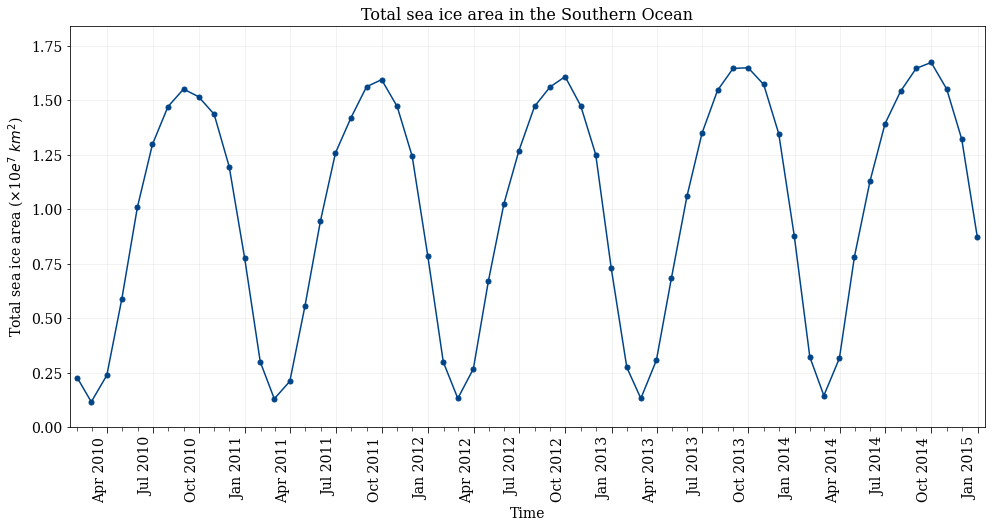

In [15]:
#The sum of sea ice area will be calculated along all longitudes and latitudes
TotalSI = SOSIarea.sum('xt_ocean').sum('yt_ocean')

#Extracting dates information and turning them into pandas datetimes
Dates = TotalSI.indexes['time'].to_datetimeindex()

#Change global font and font size
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Extract information about the plot (figure and axes)
fig, ax = plt.subplots(figsize = (16.4, 8.2))
#Using Dates information to plot dates. Transforming area units from m2 to km2.
ax.plot(Dates, TotalSI.values*1e-6, 
        #Line and and point plot. Changing color
        linestyle = '-', color = "#004488", marker = 'o', markersize = 5)

#Adding a main title to the plot - Increasing font size
plt.title('Total sea ice area in the Southern Ocean', fontsize = 16)

#Changing y axes
#Calculating the exponent of scientific notation in the y axis
exp_yaxis = np.floor(np.log10(max(ax.get_yticks()))).astype(int)
#The $ signs wrap the expression with special characters, the {} is used either as a placeholder or to 
#include more than one character in an expression
plt.ylabel(r'Total sea ice area ($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
#Changing the limits of the y axis. Max value is 10% more than maximum value in the data
plt.ylim(0, np.floor(max(TotalSI).values*1e-6*1.1))
#Removing the scientific notation from the top of the graph as it is already included in the y label
ax.yaxis.get_offset_text().set_visible(False)

#Changing x axis
#Change axes labels
plt.xlabel('Time')
#Extract min and max dates
datemin = min(Dates) - dt.timedelta(days = 15)
datemax = max(Dates) + dt.timedelta(days = 15)
#Setting x axis limits
ax.set_xlim(datemin, datemax)
#Change ticks and label position
#Major ticks to be located every third month
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))
#Minor ticks to be located every month
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval = 1))
#Change length of ticks - smaller for minor ticks
ax.tick_params(axis = 'x', which = "minor", length = 4)
ax.tick_params(axis = 'x', which = "major", length = 6)
#Change the format of the dates shown (month abbreviation and year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
#Rotating the x axis labels 90 deg to avoid label overlapping
fig.autofmt_xdate(rotation = 90)

#Set major gridlines to appear, but with high transparency
ax.grid(True, color = "#b4b4b4", linestyle = '-', alpha = 0.2)

#Save figure to local folder
plt.savefig("../Outputs/Figures/TimeSeriesSeaIce.tiff", dpi = 300)

#Automated path to save ouput
# os.path.join('../Outputs/Figures', ('TimeSeriesSeaIce' + str(datemin.year) + '-' + str(datemax.year-1) + '.tiff'))

In [16]:
#Remove variables no longer in use
del datemax, datemin, exp_yaxis, TotalSI

**Mean monthly sea ice area**

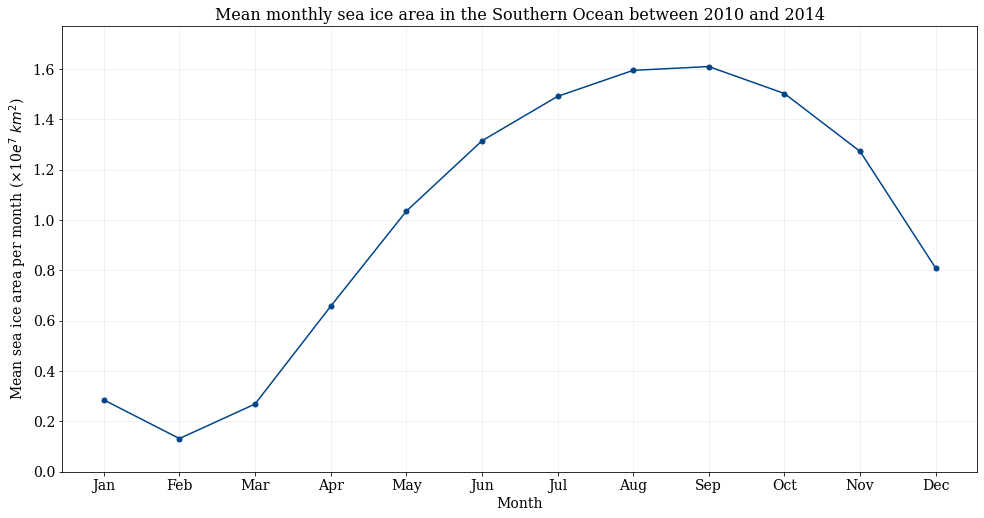

In [17]:
#The sum of sea ice area will be calculated along all longitudes and latitudes
MonMSI = SOSIarea.groupby('time.month').mean('time').sum('xt_ocean').sum('yt_ocean')
#Extracting months (in numbers) and changing to month abbreviation
Months = [calendar.month_abbr[m] for m in MonMSI.month.values]

#Extracting maximum and minimum year information
MinY = min(SOSIarea.indexes['time'].to_datetimeindex().year)
MaxY = max(SOSIarea.indexes['time'].to_datetimeindex().year)

#Change global font and font size
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Extract information about the plot (figure and axes)
#Figure size set to 8.2" wide and 4.1" tall (fits across A4)
fig, ax = plt.subplots(figsize = (16.4, 8.2))
#Using Dates information to plot dates. Transforming area units from m2 to km2.
ax.plot(Months, MonMSI.values*1e-6, 
        #Line and and point plot. Changing color
        linestyle = '-', color = "#004488", marker = 'o', markersize = 5)

#Adding a main title to the plot - Increasing font size
plt.title('Mean monthly sea ice area in the Southern Ocean between {} and {}'.format(MinY, MaxY), 
          fontsize = 16)

#Changing y axes
#Calculating the exponent of scientific notation in the y axis
exp_yaxis = np.floor(np.log10(max(ax.get_yticks()))).astype(int)
#The $ signs wrap the expression with special characters, the {} is used either as a placeholder or to 
#include more than one character in an expression
plt.ylabel(r'Mean sea ice area per month ($\times$10$e^{}$ $km^2$)'.format(exp_yaxis))
#Changing the limits of the y axis. Max value is 10% more than maximum value in the data
plt.ylim(0, np.floor(max(MonMSI).values*1e-6*1.1))
# #Removing the scientific notation from the top of the graph as it is already included in the y label
ax.yaxis.get_offset_text().set_visible(False)

#Changing x axis
#Change axes labels
plt.xlabel('Month')

#Set major gridlines to appear, but with high transparency
ax.grid(True, color = "#b4b4b4", linestyle = '-', alpha = 0.2)

#Save figure to local folder
plt.savefig("../Outputs/Figures/MonthlyMeanSeaIce.tiff", dpi = 300)

#Automated path to save figures
# os.path.join('../Outputs/Figures', ('MonthlyMeanSeaIce' + str(MinY) + '-' + str(MaxY) + '.tiff'))

In [18]:
#Remove variables no longer in use
del Months, MonMSI

**Map showing mean seasonal sea ice area**

To use the scientific colour maps by Crameri 2018, the colour palette selected needs to be uploaded first so matplotlib can access it. This can be done using the lines of code below:  
`from matplotlib.colors import LinearSegmentedColormap` This allows us to call the function to define a new colour palette  
`cm_data = np.loadtxt("../../ScientificColourMaps6/oslo/oslo.txt")` The textfile containing the information defining the palette of interest, in this case `oslo`, is loaded to a variable. Note that the complete file path is given.  
`oslo_map = LinearSegmentedColormap.from_list('oslo', cm_data)` Now we define `oslo_map` as a new color palette in matplotlib.  
Once the colour palette has been defined, it can be used in plots by simply calling its name using the cmap argument.  
`SeasonSI.sel(season = "JJA").plot(cmap = oslo_map)`.  
If these palettes are used, they should be properly cited using either of the citations below. See documentation for additional information:  
Crameri, F. (2018), Scientific colour-maps, Zenodo, doi:10.5281/zenodo.1243862
Crameri, F. (2018), Geodynamic diagnostics, scientific visualisation and StagLab 3.0, Geosci. Model Dev., 11, 2541-2562,
doi:10.5194/gmd-11-2541-2018  
Guidelines on how to choose a good colour palette can be found here: [http://www.fabiocrameri.ch/colourmap-type.php]

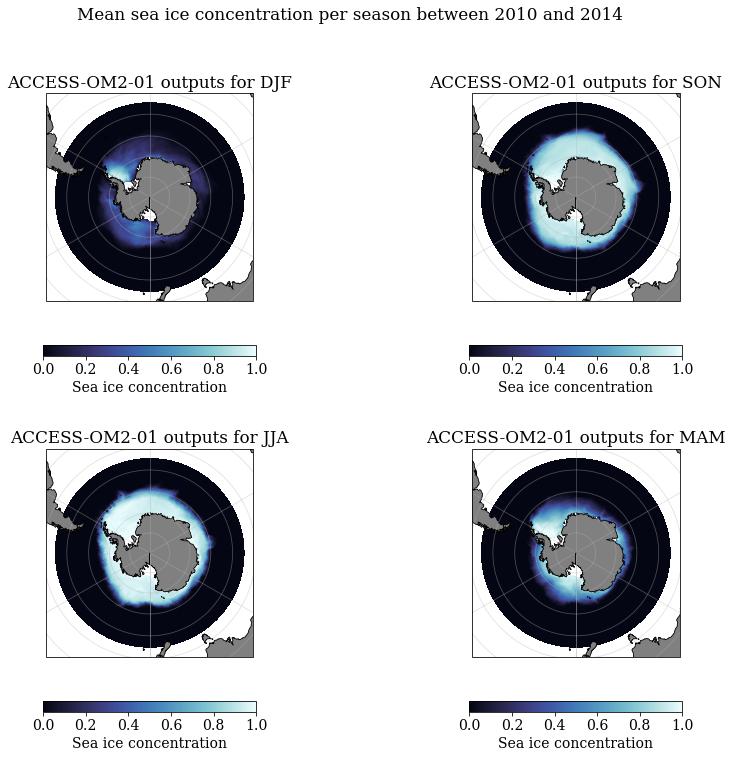

In [48]:
#The sum of sea ice area will be calculated along all longitudes and latitudes
SeasonSI = SOarr.groupby('time.season').mean('time')

#Change global font and font size
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Sea ice extent defined as the 15% concentration contour
contIce = 0.15

#Stretch the colourbar to emphasise the differences in high and low sea ice concentration areas
cmap_gamma = 2. # exponent for power-law stretch of colormap
cbar_ticks = [f**cmap_gamma for f in [0,.3,.4,.5,.6,.7,.8,.85,.9,.95,1]]

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)

#Create composite figures
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 12), 
                         subplot_kw = dict(projection = projection))
#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'DJF'), (1, 1, 'MAM'), (1, 0, 'JJA'), (0, 1, 'SON')]:
    #Extract information for each season and start plotting
    #pcolormesh creates a pseudo color map with a non-rectangular grid
    p1 = SeasonSI.sel(season = season).plot.pcolormesh(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i, j], 
                                                       #Setting color palette and min-max values for colourbar
                                                       cmap = cm.cm.ice, vmin = 0, vmax = 1, 
                                                       #Remove colourbar to allow for further manipulation
                                                       transform = ccrs.PlateCarree(), add_colorbar = False)
    #Set title for each subplot and remove x and y axes labels
    axes[i,j].set_title('ACCESS-OM2-01 outputs for ' + season)
    axes[i,j].set_ylabel("")
    axes[i,j].set_xlabel("")
    #Add the 15% contour on top of map showing concentration
    
    #Change the colourbars for each figure
    cb = fig.colorbar(p1, ax = axes[i,j], orientation = 'horizontal', shrink = 0.6)
    #Set title for colourbar
    cb.ax.set_xlabel('Sea ice concentration')

#Changing global parameters
for ax in axes.flat:
    ax.coastlines(resolution = '50m')
    ax.add_feature(land_50m)
    ax.gridlines(color = "#b4b4b4", alpha = 0.4)

#Removes white space
plt.tight_layout()
#Set title for composite figure
fig.suptitle('Mean sea ice concentration per season between ' + str(MinY) + ' and '+ str(MaxY))

#Save figure to local folder
# plt.savefig("../Outputs/Figures/SeasonalMeanSeaIce.tiff", dpi = 300)

#Automated path to save figures
# os.path.join('../Outputs/Figures', ('MonthlyMeanSeaIce' + str(MinY) + '-' + str(MaxY) + '.tiff'))

In [ ]:
#Defining colour palette from Scientific Colour Maps
from matplotlib.colors import LinearSegmentedColormap
cm_data = np.loadtxt("../../ScientificColourMaps6/oslo/oslo.txt")
oslo_map = LinearSegmentedColormap.from_list('oslo', cm_data)

#Calling libraries to edit long and lat labels
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#The sum of sea ice area will be calculated along all longitudes and latitudes
SeasonSI = SOarr.groupby('time.season').mean('time')

#Defining season names
seasonName = {'DJF': 'Austral summer', 'MAM': 'Austral autumn', 'JJA': 'Austral winter', 'SON': 'Austral spring'}

#Change global font and font size
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Sea ice extent defined as the 15% concentration contour
contIce = 0.15
#Define the contour lines to be shown in the graph. From 0 to 1 and increasing by 0.05.
levels = np.arange(0, 1.01, .005)

#Stretch the colourbar to emphasise the differences in high and low sea ice concentration areas
cmap_gamma = 2. # exponent for power-law stretch of colormap
cbar_ticks = [f**cmap_gamma for f in [0, .3, .4, .5, .6, .7, .8, .85, .9, .95, 1]]

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', facecolor = 'gray', linewidth = 0.5)

#Create composite figures
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 12), 
                         subplot_kw = dict(projection = projection))
#Create counter using a list: i and j define the plot, while season refers to season
for i, j, season in [(0, 0, 'DJF'), (1, 1, 'MAM'), (1, 0, 'JJA'), (0, 1, 'SON')]:
    #Extract information for each season and start plotting
    #pcolormesh creates a pseudo color map with a non-rectangular grid
    #cmap_gamma to be applied as exponent to data being plotted
    p1 = (SeasonSI.sel(season = season)**cmap_gamma).\
    plot.contourf(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i, j], 
                  #Setting oslo as color palette and defining min-max values for colourbar
                  cmap = oslo_map, vmin = 0, vmax = 1, 
                  #Setting contour levels
                  levels = levels,
                  #Remove colourbar to allow for further manipulation
                  transform = ccrs.PlateCarree(), add_colorbar = False)
    SeasonSI.sel(season = season).plot.contour(x = 'xt_ocean', y = 'yt_ocean', ax = axes[i,j],
                                               levels = [0.15], colors = 'white', linewidths = 1,
                                               transform = ccrs.PlateCarree())
    #Set title for each subplot and remove x and y axes labels
    if season in seasonName:
        axes[i,j].set_title(seasonName[season] + 'mean (' + season + ')')
    axes[i,j].set_ylabel("")
    axes[i,j].set_xlabel("")
    
    #Change the colourbars for each figure
    #Set values outside the upper limit to be gray
    p1.cmap.set_over(color = '#e7e4d9', alpha = None)
    #Set colourbar to be horizontal, 40% its original size and a distance equal to 7.5% of total figure area from the plot
    cb = fig.colorbar(p1, ax = axes[i,j], orientation = 'horizontal', shrink = 0.5, pad = 0.075)
    #Set title for colourbar
    cb.ax.set_xlabel('Sea ice concentration')
    #Setting colourbar ticks and labels
    cb.set_ticks(cbar_ticks)
    cb.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])

#Changing other parameters
for ax in axes.flat:
    #Coastlines to appear
    ax.coastlines(resolution = '50m')
    #Add feature loaded at the beginning of this section
    ax.add_feature(land_50m)
    #Set the extent of maps
    ax.set_extent([-280, 80, -80, -55], crs = ccrs.PlateCarree())
    #Adding gridlines gridlines - Removing any labels inside the map on the y axis
    gl = ax.gridlines(draw_labels = True, y_inline = False)
    #Change gridline color
    ax.gridlines(color = "#b4b4b4", alpha = 0.4)
    #Remove labels from everywhere except the left and right (longitude only)
    gl.xlabels_left = False
    gl.ylabels_right = False
    gl.xlabels_right = False
    gl.xlabels_top = False
    #Locate longitude ticks - Set to every 30 deg
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
    #Give longitude labels the correct format for longitudes
    gl.xformatter = LONGITUDE_FORMATTER
    #Set y label colour to white to remove latitude labels that show on graph
    gl.ylabel_style = {'color': 'white'}

#Removes white space
# fig.tight_layout()
#Set title for composite figure
fig.suptitle('Mean sea ice concentration per season between ' + str(MinY) + ' and '+ str(MaxY))
fig.subplots_adjust(top = 0.95)

#Save figure to local folder
plt.savefig("../Outputs/Figures/SeasonalMeanSeaIce.tiff", dpi = 300)

#Automated path to save figures
# os.path.join('../Outputs/Figures', ('SeasonalMeanSeaIce' + str(MinY) + '-' + str(MaxY) + '.tiff'))

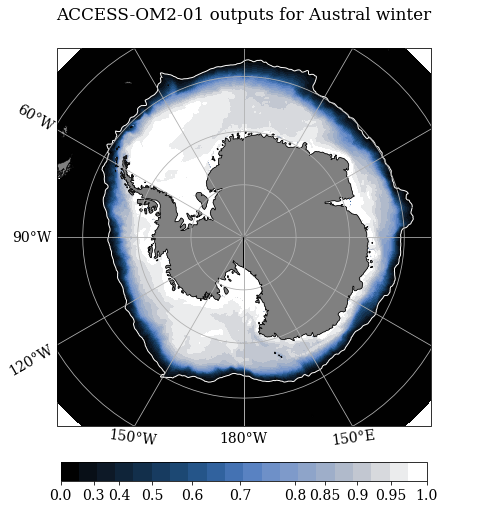

In [145]:
# %who
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

fig = plt.figure(figsize = (16.4, 8.2))
levels = np.arange(0,1.01,.05)

season = 'JJA'

wint = SeasonSI.sel(season = 'JJA')
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
gl = ax.gridlines(draw_labels = True, y_inline = False)
gl.xlabels_left = False
gl.ylabels_right = False
gl.xlabels_right = False
gl.xlabels_top = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 30))
gl.xformatter = LONGITUDE_FORMATTER
gl.ylabel_style = {'color': 'white'}

map1 = (wint**cmap_gamma).plot.contourf(ax = ax, x = 'xt_ocean', y = 'yt_ocean', cmap = oslo_map, add_colorbar = False,
                                                           transform = ccrs.PlateCarree(), levels = levels)

# plt.contour(x,y, wint, [contIce],colors='red',linewidths=1)
x = wint.plot.contour(x = 'xt_ocean', y = 'yt_ocean', levels = [0.15], colors = 'white', linewidths=1, 
                                                           transform = ccrs.PlateCarree())
#PlateCarree is the projection needed to plot lat/lon data
ax.set_extent([-280, 80, -80, -55], crs=ccrs.PlateCarree())

if season in sea:
    plt.title('ACCESS-OM2-01 outputs for ' + sea[season])

        
map1.cmap.set_over(color = oslo_map(255), alpha = None)

cb = fig.colorbar(map1, orientation = 'horizontal', pad = 0.075, shrink = 0.4)
cb.set_ticks(cbar_ticks)
cb.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
fig.subplots_adjust(top = 0.95)
# m.contour(x, y, wint, [contIce], colors = "red")